# ResNet - MindSpore

## 导入数据依赖

In [1]:
import mindspore.nn as nn
from mindspore import dtype as mstype
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as C
import mindspore.dataset.transforms.c_transforms as C2
from mindspore import context
import numpy as np
import matplotlib.pyplot as plt
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore import save_checkpoint
import os
from mindspore import Model
from mindspore import Tensor  # mindspore的tensor

import moxing as mox
mox.file.copy_parallel(src_url="s3://nlp-zju-cxy/nlp/cifar-10-batches-bin/test/", dst_url='./test/')  # 将OBS桶中数据拷贝到容器中
mox.file.copy_parallel(src_url="s3://nlp-zju-cxy/nlp/cifar-10-batches-bin/train/", dst_url='./train/')
mox.file.copy_parallel(src_url="s3://nlp-zju-cxy/nlp/vqa/CNN/resnet.py", dst_url='./resnet.py')

context.set_context(mode=context.GRAPH_MODE, device_target="Ascend")

INFO:root:Using MoXing-v2.0.0.rc2.4b57a67b-4b57a67b
INFO:root:Using OBS-Python-SDK-3.20.9.1


## 读取Cifar10数据集

In [2]:
def create_dataset(data_home, repeat_num=1, batch_size=32, do_train=True, device_target="Ascend"):
    """
    create data for next use such as training or inferring
    """

    cifar_ds = ds.Cifar10Dataset(data_home,num_parallel_workers=8, shuffle=True)

    c_trans = []
    if do_train:
        c_trans += [
            C.RandomCrop((32, 32), (4, 4, 4, 4)),
            C.RandomHorizontalFlip(prob=0.5)
        ]

    c_trans += [
        C.Resize((224, 224)),
        C.Rescale(1.0 / 255.0, 0.0),
        C.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        C.HWC2CHW()
    ]

    type_cast_op = C2.TypeCast(mstype.int32)

    cifar_ds = cifar_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=8)
    cifar_ds = cifar_ds.map(operations=c_trans, input_columns="image", num_parallel_workers=8)

    cifar_ds = cifar_ds.batch(batch_size, drop_remainder=True)
    cifar_ds = cifar_ds.repeat(repeat_num)

    return cifar_ds


ds_train_path = "./train/"
dataset_show = create_dataset(ds_train_path)
with open(ds_train_path+"batches.meta.txt","r",encoding="utf-8") as f:
    all_name = [name.replace("\n","") for name in f.readlines()]

iterator_show= dataset_show.create_dict_iterator()
dict_data = next(iterator_show)
images = dict_data["image"].asnumpy()
labels = dict_data["label"].asnumpy()
count = 1
#%matplotlib inline
for i in images:
    plt.subplot(4, 8, count)
    # Images[0].shape is (3,224,224).We need transpose as (224,224,3) for using in plt.show().
    picture_show = np.transpose(i,(1,2,0))
    picture_show = picture_show/np.amax(picture_show)
    picture_show = np.clip(picture_show, 0, 1)
    plt.title(all_name[labels[count-1]])
    picture_show = np.array(picture_show,np.float32)
    plt.imshow(picture_show)
    count += 1
    plt.axis("off")
# """
# print("The dataset size is:", dataset_show.get_dataset_size())
# print("The batch tensor is:",images.shape)
# plt.show()
# """

## 训练ResNet

In [3]:
import resnet as rn
import mindspore.nn as nn
from mindspore.nn import SoftmaxCrossEntropyWithLogits
net = rn.resnet50(batch_size=32, num_classes=10)
ls = SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
opt = nn.Momentum(filter(lambda x: x.requires_grad, net.get_parameters()), 0.01, 0.9)

model = Model(net, loss_fn=ls, optimizer=opt, metrics={'acc'})
# As for train, users could use model.train

epoch_size = 10
ds_train_path = "./train/"
model_path = "./ckpt/"

dataset = create_dataset(ds_train_path )
batch_num = dataset.get_dataset_size()
print(batch_num)
config_ck = CheckpointConfig(save_checkpoint_steps=batch_num, keep_checkpoint_max=35)
ckpoint_cb = ModelCheckpoint(prefix="train_resnet_cifar10", directory="./ckpt/", config=config_ck)
loss_cb = LossMonitor(142)
model.train(epoch_size, dataset, callbacks=[ckpoint_cb, loss_cb])
# save_checkpoint(model.train_network, 'resnet.ckpt')
# mox.file.copy_parallel(src_url='./resnet.ckpt', dst_url='s3://nlp-zju-cxy/nlp/resnet.ckpt')


#验证准确性和可视化
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range 
# """
# #成功保存后加上
# param_dict = load_checkpoint("./ckpt/train_resnet_cifar10-10_1562.ckpt")
# load_param_into_net(net, param_dict)
# """

1562
epoch: 1 step: 1562, loss is 1.2499065
epoch: 2 step: 1562, loss is 0.98616487
epoch: 3 step: 1562, loss is 0.7768481
epoch: 4 step: 1562, loss is 1.2276807
epoch: 5 step: 1562, loss is 0.54724437
epoch: 6 step: 1562, loss is 0.3704913
epoch: 7 step: 1562, loss is 0.49336052
epoch: 8 step: 1562, loss is 0.22340249
epoch: 9 step: 1562, loss is 0.24694282
epoch: 10 step: 1562, loss is 0.5110347


## 测试网络

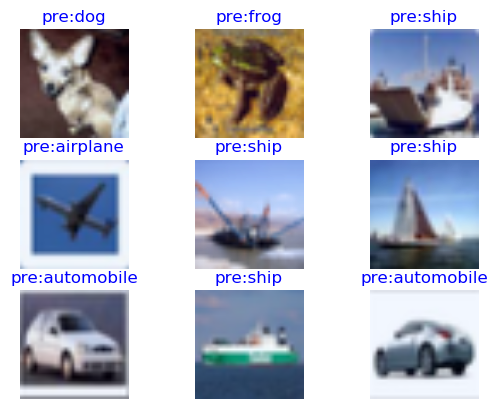

result:  {'acc': 0.8188100961538461}


In [4]:
ds_eval_path = "./test/"
eval_dataset = create_dataset(ds_eval_path, do_train=False)
data = next(eval_dataset.create_dict_iterator())
images = data["image"].asnumpy()
labels = data["label"].asnumpy()
output = model.predict(Tensor(data['image']))
class_name = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
pred = np.argmax(output.asnumpy(),axis=1)
for i in range(len(labels)):
        plt.subplot(3,3,i+1)
        color = 'blue' if pred[i] == labels[i] else 'red'
        plt.title('pre:{}'.format(class_name[pred[i]]), color=color)
        picture_show = np.transpose(images[i],(1,2,0))
#         picture_show = picture_show/np.amax(picture_show)
#         picture_show = np.clip(picture_show, 0, 1)
        picture_show = normalization(picture_show)
        plt.imshow(picture_show)
        plt.axis('off')
        if i >= 8:
            break
plt.show()

res = model.eval(eval_dataset)
print("result: ", res)